In [ ]:
import * as nn from "../index.ts"

class Model extends nn.Module {
  linear: nn.Linear;
  linear2: nn.Linear;

  constructor(input_size: number, output_size: number) {
    super();
    this.linear = new nn.Linear(input_size, 10);
    this.linear2 = new nn.Linear(10, output_size);
    this.register_parameters([this.linear, this.linear2]);
  }

  override forward(x: nn.Tensor): nn.Tensor {
    return this.linear2.$(this.linear.$(x));
  }
}


In [ ]:
function create_data(start: number, end: number, num_points: number): { x: nn.Tensor, y: nn.Tensor }[] {
  const data = [];
  for (let i = 0; i < num_points; i++) {
    const x = nn.Tensor.fromArray([start + (end - start) * i / (num_points - 1)], [1, 1], false); // Input data shouldn't require gradients
    const y = new nn.Tensor([Math.sin(x.data[0])], [1, 1]);
    data.push({ x: x, y: y });
  }
  return data;
}


const data = create_data(-20, 20, 1000);
data[0].x.data

Float32Array(1) [ -20 ]

In [3]:
const model = new Model(1, 1);
const optimizer = new nn.SGD(model.parameters, 0.001);

In [11]:
model.linear.weights.shape

[ 1, 10 ]

In [4]:
console.log(model.summary());

Linear(in_features=1, out_features=10): Parameter: 1x10
  Parameter: 1x10
Linear(in_features=10, out_features=1): Parameter: 10x1
  Parameter: 1x1


In [5]:
let total_loss: number[] = [];
for (let i = 0; i < 100; i++) {
  let epoch_loss: number[] = [];
  for (const { x, y } of data) {
    const output = model.$(x);
    const loss = nn.mean(nn.pow(nn.sub(output, y), 2));
    loss.backward();
    optimizer.step();
    epoch_loss.push(loss.data[0]);
    optimizer.zeroGrad();
  }
  let loss = epoch_loss.reduce((a, b) => a + b, 0) / epoch_loss.length
  console.log("Epoch loss:", loss);
  epoch_loss = [];
  total_loss.push(loss)
}
console.log("Total loss:", total_loss.reduce((a, b) => a + b, 0));


Epoch loss: 13.143708383185333


Epoch loss: 0.029090127981200198
Epoch loss: 0.03874591906785722
Epoch loss: 0.026753975581521018
Epoch loss: 0.03216044470901177
Epoch loss: 0.02755357801989129
Epoch loss: 0.030123533669263337
Epoch loss: 0.028241575195919924
Epoch loss: 0.029399266753229486
Epoch loss: 0.028606694033900915
Epoch loss: 0.029119738910970597
Epoch loss: 0.028782338270188147
Epoch loss: 0.029010263604031115
Epoch loss: 0.028867577560504388
Epoch loss: 0.028971016380218675
Epoch loss: 0.028912979644464373
Epoch loss: 0.02896254949462947
Epoch loss: 0.02894176011890485
Epoch loss: 0.02896832488471105
Epoch loss: 0.02896445542459517
Epoch loss: 0.028981620479830383
Epoch loss: 0.02898579448298317
Epoch loss: 0.02899942781167707
Epoch loss: 0.02900780325647543
Epoch loss: 0.029020699445944816
Epoch loss: 0.029031630807755324
Epoch loss: 0.029044922529322455
Epoch loss: 0.029057644058701627
Epoch loss: 0.029071816741370243
Epoch loss: 0.029086176990569583
Epoch loss: 0.02910154301943561
Epoch loss: 0.0291174

In [ ]:
// total_loss

[
    13.143708383185333, 0.029090127981200198,  0.03874591906785722,
  0.026753975581521018,  0.03216044470901177,  0.02755357801989129,
  0.030123533669263337, 0.028241575195919924, 0.029399266753229486,
  0.028606694033900915, 0.029119738910970597, 0.028782338270188147,
  0.029010263604031115, 0.028867577560504388, 0.028971016380218675,
  0.028912979644464373,  0.02896254949462947,  0.02894176011890485,
   0.02896832488471105,  0.02896445542459517, 0.028981620479830383,
   0.02898579448298317,  0.02899942781167707,  0.02900780325647543,
  0.029020699445944816, 0.029031630807755324, 0.029044922529322455,
  0.029057644058701627, 0.029071816741370243, 0.029086176990569583,
   0.02910154301943561,  0.02911743906518869, 0.029134143084318977,
  0.029151469993335056,  0.02916955187995019,  0.02918836277704992,
   0.02920786845040617,  0.02922808439109504, 0.029249105356556157,
    0.0292708414845707,  0.02929325782210664, 0.029316523003151664,
   0.02934043179691919,  0.02936512371673513, 

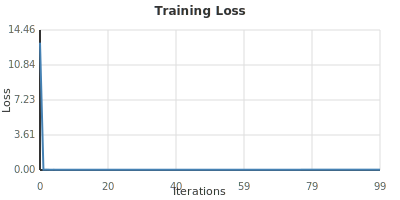

In [8]:
const svg = plotLossSVG(total_loss);
Deno.jupyter.svg`${svg}`;